In [50]:
import os
import glob
import pandas as pd
import numpy as np
from scipy import interpolate
from itertools import chain
from multiprocessing import Pool
import math
import re
import h5py

In [2]:
from LBL_funcs_fullSpectrum import *
from LBL_funcs_plotting import *
from LBL_funcs_inclined import *

In [157]:
data_dir = './lut_test_file/'
Fls = os.listdir(data_dir)
Fls = [f for f in Fls if f.endswith('.npy')]
Fls = [f for f in Fls if f.startswith('Results')]
Fls[0]

'Results_case2_TWP=36.249_AOD=0.1243_COD=50.0_kap=[10, 11, 12]_th0=45.npy'

In [107]:
F_dw = np.load(data_dir +'/'+Fls[0],  allow_pickle=True).item().get('F_dw')
F_dw.shape

(10834,)

In [15]:
results = channel_oswr(data_dir,Fls[0])
#results = list(chain(*results))

# export
df = pd.DataFrame(results)
df = df.sort_index()
df

,TPW,COD,kap,kap_top,kap_bottom,AOD,channel,OSWR
0,36.249,50.0,"[10, 11, 12]",12,10,0.1243,C01,47.444557
1,36.249,50.0,"[10, 11, 12]",12,10,0.1243,C02,126.785714
2,36.249,50.0,"[10, 11, 12]",12,10,0.1243,C03,71.817128
3,36.249,50.0,"[10, 11, 12]",12,10,0.1243,C04,0.966525
4,36.249,50.0,"[10, 11, 12]",12,10,0.1243,C05,5.137779
5,36.249,50.0,"[10, 11, 12]",12,10,0.1243,C06,3.992420


In [ ]:
if __name__ == "__main__":
    for timeofday in ["day"]:
        data_dir = './lut_test_file/'
        spectral = 'SW'
        preprocess_model_oswr(data_dir=data_dir, timeofday=timeofday)   # OLR [W/m^2]
        preprocess_model_dsw(data_dir=data_dir, timeofday=timeofday)   # DLW [W/m^2]

    # compare model against measured data
    data_dir = os.path.join("data")      # directory with SURFRAD+GOES data
    #for sky in ["clear", "cloudy", "day", "night"]:
    #for sky in ["cloudy", "day"]:
    for sky in ["cloudy"]:
        #sites = ["BON", "DRA", "FPK", "GWN", "PSU", "SXF", "TBL"]
        sites = ["AKA"]
        # sites = ["DRA", "FPK", "GWN", "PSU", "SXF", "TBL"]
        #sites = ["DRA", "FPK", "GWN"]
        #sites = ["PSU", "SXF", "TBL"]
        for site in sites:
            print(sky, site)
            ## interpolate OLR and DLW to ground conditions (T, RH)
            compare_oswr(site, sky=sky, data_dir=data_dir)
            compare_dlw(site, sky=sky, data_dir=data_dir)

            # estimate the cloud optical properties
            postprocess_olr(site, sky=sky)
            postprocess_dlw(site, sky=sky)

# files: 1
OSWR: (6, 8)
TPW: [36.249, 36.249, 36.249, 36.249, 36.249, 36.249]
# files: 1
DSW: (1, 8)
TPW: [36.249]
cloudy AKA


NameError: name 'compare_olr' is not defined

## Convert the uw_rxyz_M to radiance [W/m2 $\cdot$ sr]

1. set the bin of theta and azimuth

2. calculate the Intensity at each bin

3. convert Intensity to reflectance

4. time the RSF

In [100]:
filenames = ["uwxyzr_COD=10.0_th0=45_TWP=7.169.npy"]
results = np.load(data_dir + filenames[0],allow_pickle=True).item()
uw_rxyz_M = results.get('uw_rxyz_M')

In [171]:
dnu = 3# speactral resolution 0.1 is enough, 0.01 is too fine, especially for cloudy periods
nu=np.arange(2500,35000,dnu)
data = np.genfromtxt('data/profiles/ASTMG173.csv', delimiter=',', skip_header=2,  # in wavenumber basis
                     names=['wavelength', 'extraterrestrial', '37tilt', 'direct_circum'])
ref_lam = data['wavelength']  # nm avoid hearder 1
ref_E = data['extraterrestrial']
ref_E_nu = -ref_E * ref_lam ** 2 / 1e7  # W/[m2*nm-1] tp W/[m2*cm-1]
F_dw_os = -np.interp(-nu, -1e7 / ref_lam, ref_E_nu)

### LUT: (solar zenith angle, COD, LUT) name


GOES: theta_v=np.arange(0,91,2) # we only have 0,15,30,45,60,75,90


us: th0_v = np.array([0,15,30,45,60,65])

some note:
- (lot,lat) of a station is not important
- It is important :
    - (1) the local zenith angle, 
    - (2) the relative azimuth angle between solar and satellite

In [173]:
theta0 = 45
phi0 = 0
N_bundles = 1000
CODi = 10.0
# Step 1: calculate the Intensity table for one solar zenith
In = cal_Intensity(data_dir + filenames[0], theta0, phi0, nu,
                    F_dw_os, N_bundles, is_flux=False, Norm=False, dirc='UW')
# Next step: save all the intensity in a table for one solar zenith
with h5py.File(data_dir+f'COD={CODi}_th0={theta0}.h5', 'w') as f:
    f.create_dataset('theta_phi_loc', data=In)

In [174]:
# Extract Intensity of interest = [relative diff of azimuth angle, local zenith index]
# we have to ensure : the model outputted Intensity is normalized to the sun-earth average distance
# Input angles
thetai = 15
phij = -120

i,j = find_bin_indices(thetai, phij)
# Open the HDF5 file and extract an element
with h5py.File(data_dir+f'COD={CODi}_th0={theta0}.h5', 'r') as f:
    dataset = f['theta_phi_loc']
    element = dataset[i, j]  # Example: extract the element at row 10, column 10
    print(f"Extracted element: {element}")
d=sun_earth_dis(day=3,month=12,year=2024,latitude = 40.7128,longitude = -74.0060, elevation = 10)
ref = Intensity2reflectance(element, F_dw_os[2], d)
ref # the simulated ref, for comparison with the real FY4A data

Extracted element: 106.77127509011208
Sun's Right Ascension: 16h 37m 32.57s
Sun's Declination: -22deg 05' 07.8"
Distance to the Sun (in AU): 0.985816622511662


1.0

### important: why do we choose theta_bin ?

In [344]:
np.linspace(0, 65, 101)

array([ 0.  ,  0.65,  1.3 ,  1.95,  2.6 ,  3.25,  3.9 ,  4.55,  5.2 ,
        5.85,  6.5 ,  7.15,  7.8 ,  8.45,  9.1 ,  9.75, 10.4 , 11.05,
       11.7 , 12.35, 13.  , 13.65, 14.3 , 14.95, 15.6 , 16.25, 16.9 ,
       17.55, 18.2 , 18.85, 19.5 , 20.15, 20.8 , 21.45, 22.1 , 22.75,
       23.4 , 24.05, 24.7 , 25.35, 26.  , 26.65, 27.3 , 27.95, 28.6 ,
       29.25, 29.9 , 30.55, 31.2 , 31.85, 32.5 , 33.15, 33.8 , 34.45,
       35.1 , 35.75, 36.4 , 37.05, 37.7 , 38.35, 39.  , 39.65, 40.3 ,
       40.95, 41.6 , 42.25, 42.9 , 43.55, 44.2 , 44.85, 45.5 , 46.15,
       46.8 , 47.45, 48.1 , 48.75, 49.4 , 50.05, 50.7 , 51.35, 52.  ,
       52.65, 53.3 , 53.95, 54.6 , 55.25, 55.9 , 56.55, 57.2 , 57.85,
       58.5 , 59.15, 59.8 , 60.45, 61.1 , 61.75, 62.4 , 63.05, 63.7 ,
       64.35, 65.  ])

In [351]:
import numpy as np
import matplotlib.pyplot as plt
def theta_bin():

    # Step 1: Create x and calculate y
    x = np.linspace(0, 65, 101)
    #x = np.radians(x)
    y = np.cos(np.radians(x))  # Convert degrees to radians for cosine

    # Step 2: Create y_extract with 11 evenly spaced values between 0 and 1
    y_extract = np.linspace(np.cos(65/180*np.pi), 1, 46)
    #print(y_extract)

    # Step 3: Interpolate to find corresponding x values for y_extract
    # Use numpy's interpolation function
    x_extract = np.interp(y_extract, y[::-1], x[::-1])

    # Print the results
    #for i in range(len(y_extract)):
    #    print(f"y_extract: {y_extract[i]:.2f}, Corresponding x: {90-x_extract[i]:.2f} degrees")
    
    # Optional: Plotting for visualization
    plt.plot(x, y, label='y = cos(x)', color='blue')
    plt.scatter(x_extract, y_extract, color='red', label='Extracted Points')
    plt.scatter(65-x_extract, y_extract, color='green', label='Extracted Points')
    plt.title('Cosine Function with Extracted Points')
    plt.xlabel('x (degrees)')
    plt.ylabel('y (cos(x))')
    plt.legend(loc='lower center')
    plt.grid()
    plt.show()
    theta_bin = np.round(65-x_extract,2)
    print(theta_bin)
    return theta_bin

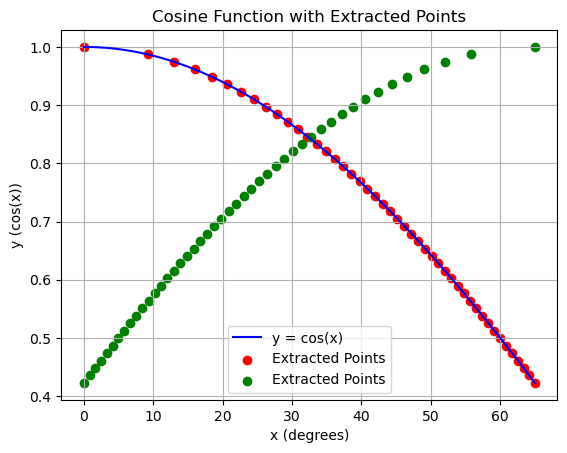

[ 0.    0.81  1.63  2.46  3.29  4.13  4.97  5.83  6.69  7.55  8.43  9.32
 10.21 11.12 12.03 12.96 13.9  14.85 15.81 16.79 17.78 18.79 19.82 20.87
 21.93 23.02 24.13 25.27 26.43 27.63 28.86 30.12 31.43 32.78 34.19 35.66
 37.19 38.81 40.53 42.37 44.37 46.57 49.05 51.99 55.81 65.  ]


In [352]:
theta_bin = theta_bin()

# Functions

## preprocess_model_oswr

In [131]:
def preprocess_model_oswr(data_dir=None, timeofday="day"):
    """
    Process OSWR model results.
    OLR (Outgoing Longwave Radiation) [W/m2]
    OSWR (Outgoing Shortwave Radiation) [W/m2]
    """
    dnu = 3
    n_layers = 54

    Fls = os.listdir(data_dir)
    Fls = [f for f in Fls if f.endswith('.npy')]
    Fls = [f for f in Fls if f.startswith('Results')]
    print("# files:", len(Fls))

    # parallel process files
    # pool = Pool()
    # results = pool.map(channel_oswr, Fls)
    # pool.close()
    # extract channel result and *RSF
    results = channel_oswr(data_dir,Fls[0])
    #results = list(chain(*results))

    # export
    df = pd.DataFrame(results)
    df = df.sort_index()

    # Convert object types to specific types
    df['kap'] = df['kap'].astype(str)
    df['channel'] = df['channel'].astype(str)

    df.to_hdf(
        path_or_buf="results_{}layers_{:.2f}_OSWR_{}.h5".format(n_layers, dnu, timeofday),
        key="df",
        mode="w")

    print("OSWR:", df.shape)
    # print(df.columns)
    # print("kap:", sorted(df["kap"]))
    # print(sorted(df["kap_top"].unique()))
    # print(sorted(df["kap_bottom"].unique()))
    print("TPW:", sorted(df["TPW"]))
    return None

In [ ]:
def channel_oswr(data_dir, filename):
    """Channel Outgoing Shortwave Radiation [W/m^2]."""

    pattern = r'TWP=([0-9.]+)_AOD=([0-9.]+)_COD=([0-9.]+)_kap=\[([0-9, ]+)\]_th0=([0-9.]+)'
    match = re.search(pattern, filename)
    if match:
        TPW, AOD, COD, kap_str, th0 = match.groups()
        TPW, AOD, COD, th0 = map(float, [TPW, AOD, COD, th0])
        kap = list(map(int, kap_str.split(',')))
        kap_top, kap_bottom = kap[-1], kap[0]
    else:
        print("No match:", filename)
    data = np.load('data/computed/F_dw_os_SW.npz')
    nu, F_dw_os = data['nu'], data['f_dw_os']
    del data

    # Create the desired string
    #filenames = ["uwxyzr_COD=10.0_th0=45_TWP=7.169.npy"]
    uw_rxyz_file = f"uwxyzr_COD={COD}_th0={th0}_TWP={TPW}.npy"
    file_path = os.path.join(data_dir, uw_rxyz_file)
    try:
        In_toa = cal_Intensity(file_path, th0, nu, F_dw_os, 
                           is_flux=False, Norm=False, dirc='UW')
    except FileNotFoundError:
        raise ValueError(f"No matched Uw_rxyz_file found for {uw_rxyz_file}")
    #toa = np.load(data_dir +'/'+filename,  allow_pickle=True).item().get('F_uw')

    # Next step: save all the intensity in a table for one solar zenith
    with h5py.File(data_dir+f'COD={CODi}_th0={theta0}.h5', 'w') as f:
        f.create_dataset('theta_phi_loc', data=In)

    # remove invalid data
    idx = ~np.isnan(In_toa)
    In_toa = In_toa[idx]
    nu = nu[idx]

    channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
    results = []

    for channel in channels:
        # load calibration data : Spectral Response Func
        channel_number = int(channel[-2:])

        dirpath = './lut_test_file/'
        filename = os.path.join(
                    dirpath,
                    'FY4A_AGRI_SRF_ch{}_20180306.txt'.format(channel_number)
                    )
        calibration = np.genfromtxt(filename, delimiter='\t', skip_header=1)
        calibration_wl = calibration[:, 0]  # wavelength [nm]
        calibration_nu = 1e7/calibration_wl # cm-1
        calibration_srf = calibration[:, 1]/100  # relative SRF [-]

        # reverse order (so wavenumber is increasing)
        calibration_nu = calibration_nu[::-1]
        calibration_srf = calibration_srf[::-1]

        # interpolate calibration to match model
        srf = np.interp(nu, calibration_nu, calibration_srf)

        # integrate spectral radiance over the channel
        idx = (nu >= calibration_nu.min()) & (nu <= calibration_nu.max())
        In_toa_channel = In_toa[idx]
        srf_channel = srf[idx]
        nu_channel = nu[idx]
        OSWR_channel = np.trapz(np.multiply(In_toa_channel, srf_channel), x=nu_channel)
        results.append({'TPW': TPW, "COD": COD,
                        "kap": kap, "kap_top": kap_top, "kap_bottom": kap_bottom,
                        "AOD": AOD, 'channel': channel, 'OSWR': OSWR_channel})
    return results

In [135]:
def preprocess_model_dsw(data_dir=None, timeofday="day"):
    """Process downwelling shortwave model results."""

    dnu = 3
    n_layers = 54
    Fls = os.listdir(data_dir)
    Fls = [f for f in Fls if f.endswith('.npy')]
    Fls = [f for f in Fls if f.startswith('Results')]
    print("# files:", len(Fls))

    # parallel process files
    # pool = Pool()
    # results = pool.map(eppley_dlw, filenames)
    # pool.close()
    # results = list(chain(*results))  # flatten: list(list(dict)) ==> list(dict)
    results = model_dsw(data_dir, Fls[0])

    # export
    df = pd.DataFrame(results)
    df = df.sort_index()

    df['kap'] = df['kap'].astype(str)
    df['kap_top'] = df['kap_top'].astype(str)
    df['kap_bottom'] = df['kap_bottom'].astype(str)

    df.to_hdf(
        path_or_buf="results_{}layers_{:.2f}_oswr_{}.h5".format(n_layers, dnu, timeofday),
        key="df",
        mode="w")

    print("DSW:", df.shape)
    #print(df.head())
    #print(df.columns)
    # print("kap:", sorted(df["kap"]))
    #print(sorted(df["kap_top"].unique()))
    #print(sorted(df["kap_bottom"].unique()))
    print("TPW:", sorted(df["TPW"]))

In [123]:
def model_dsw(data_dir, filename):
    """DSW radiances that would be seen by Satellite devices [FY4A]."""

    # wavenumber resolution [cm^-1]
    dnu = 3

    pattern = r'TWP=([0-9.]+)_AOD=([0-9.]+)_COD=([0-9.]+)_kap=\[([0-9, ]+)\]_th0=([0-9.]+)'
    match = re.search(pattern, filename)
    if match:
        TPW, AOD, COD, kap_str, th0 = match.groups()
        TPW, AOD, COD, th0 = map(float, [TPW, AOD, COD, th0])
        kap = list(map(int, kap_str.split(', ')))
        kap_top, kap_bottom = kap[-1], kap[0]
    else:
        print("No match found.")
    data = np.load('data/computed/F_dw_os_SW.npz')
    nu = data['nu']
    del data

    F_dw = np.load(data_dir +'/'+filename,  allow_pickle=True).item().get('F_dw')

    # remove invalid data
    idx = ~np.isnan(F_dw)
    F_dw = F_dw[idx]
    nu = nu[idx]

    channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
    results = []


    # integrate downwelling radiation:
    lamb_min, lamb_max = 0.25, 4  # spectral range: 3-50 um (SURFRAD)
    nu_min, nu_max = 1/lamb_max*1e4, 1/lamb_min*1e4  # spectral range: 3.5-50 um (ARM SGP C1)
    idx = (nu >= nu_min) & (nu <= nu_max)
    dw_ = F_dw[idx]
    ghi = np.trapz(np.sort(dw_), dx=dnu)
    results = [{
        'TPW': TPW, 'th0': th0, 
        "COD": COD, "AOD": AOD,
        "kap": kap, "kap_top": kap_top, "kap_bottom": kap_bottom,
        'dwir': ghi,
    }]

    return results


In [99]:

nu_min, nu_max 

(2500.0, 40000.0)

In [57]:
def Intensity2reflectance(radiance, F_dw_os_mono, d2=0.3):
    # https://edc.occ-data.org/goes16/python/#radiance-to-reflectance
    # Define some constants needed for the conversion. From the pdf linked above
    Esun_Ch_01 = F_dw_os_mono #726.721072 
    d2 = 0.3 #earth_sun_distance_anomaly_in_AU
    # Apply the formula to convert radiance to reflectance
    ref = (radiance * np.pi * d2) / Esun_Ch_01

    # Make sure all data is in the valid data range
    ref = np.maximum(ref, 0.0)
    ref = np.minimum(ref, 1.0)
    return ref

In [180]:
def cal_Intensity(filename, theta0, nu, F_dw_os, phi0=0, N_bundles=1000, is_flux=False, Norm=False, dirc='UW'): #Z_csky
    """
    bins_theta: local zenith angle
    bin_phi: relative difference between the angle of solar azimuth and local zimuth
    solid anlge (bin_theta,bin_phi) determined to the intensity at an angle of (satellite local solar).
    """
    theta0 = theta0 / 180 * math.pi
    phi0 = 0 / 180 * math.pi
    
    d_th=2
    d_phi=5
    # GOES solar zenith 45, local zenith angle 45, relative azimuth difference angle 45
    bins_theta=np.arange(0,91,2)  
    # symmetric, so we change (-180, 180) to (0, 180)
    bins_phi= np.hstack((np.arange(0,170+5,5), np.arange(170,180+1,1)))  
    # bins_LZA = np.arange(0,88+2,2) 
    file_dir = "./"
    #Fls = os.listdir(file_dir)
    #targetregex = re.compile(r"Results_case2_COD=(\d+\.?\d*)_Tsurf=300_AOD=0\.0_COD=0\.0_th0=")
    #Fls = [f for f in Fls if f.startswith('dwxyzr_COD=1')]
    #Fls = np.sort(Fls)
    #for ifile in range(len(Fls)):
    results=np.load(filename,allow_pickle=True).item() #******
    if dirc == 'UW':
        dw_rxyz_M = results.get('uw_rxyz_M') #Mrxyz
    else:
        dw_rxyz_M = results.get('dw_rxyz_M')
    dw_rx,dw_ry,dw_rz,uw_rx,uw_ry,uw_rz=[np.zeros((N_bundles+10,len(nu)))*np.nan for i in range(0,6)]
    H=np.zeros((len(bins_theta)-1,len(bins_phi)-1))
    for k in range(0,len(nu)):
        dw_rxyz=dw_rxyz_M[k]
        N_dw=len(dw_rxyz)
        dw_rx[0:N_dw,k]=np.array([x[0] for x in dw_rxyz])
        dw_ry[0:N_dw,k]=np.array([x[1] for x in dw_rxyz])
        dw_rz[0:N_dw,k]=np.array([x[2] for x in dw_rxyz])
        if dirc == 'UW':
            theta_v,phi_v=theta_phi(dw_rx[:,k],dw_ry[:,k],dw_rz[:,k])
        else:  #DW
            theta_v,phi_v=theta_phi(dw_rx[:,k],dw_ry[:,k],-dw_rz[:,k])
        ind=np.isnan(phi_v)
        theta_v=theta_v[~ind]
        phi_v=phi_v[~ind]-phi0
        phi_v[phi_v>math.pi]-=2*math.pi
        H_k, xedges, yedges = np.histogram2d(np.rad2deg(theta_v), np.rad2deg(phi_v), bins=(bins_theta, bins_phi))
        if Norm==True:
            H+=H_k*np.cos(theta0)*1/N_bundles #*F_dw_os[k]*3/N_bundles # 3 is dnu
        else:
            H+=H_k*np.cos(theta0)*F_dw_os[k]*3/N_bundles
    for ibeta in range(0,1):
        theta_,phi_=np.meshgrid(xedges[0:-1],yedges[0:-1])
        if (not is_flux):
            ths = np.deg2rad(theta_.T + d_th / 2)  # rad dw # division 2 for the 2sintcost
            H /= 0.5 * np.sin(2 * ths)
        H/=np.deg2rad(d_th)*np.deg2rad(d_phi) # per solid angle, in the direction of beam  
    return H  

In [60]:
def find_bin_indices(thetai, phij):
    # Define the bin edges
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.hstack((np.arange(0, 170 + d_phi, d_phi), np.arange(170, 180 + 1, 1)))

    # Adjust phij to be in the range [0, 180]
    if phij > 180:
        phij = 360 - phij
    if phij < 0:
        phij = -phij

    # Find the bin indices
    i = np.digitize(thetai, bins_theta) - 1
    j = np.digitize(phij, bins_phi) - 1
    
    #print(f"Index for thetai ({thetai}): {bins_theta[i]}")
    #print(f"Index for phij ({phij}): {bins_phi[j]}")
    return i,j # intensity

# compare func

In [160]:

site = 'AKA'
sky = 'day'
sat = pd.read_hdf(
        os.path.join(data_dir, "{}_radiance_satellite_{}.h5".format(site, sky)),
        'df'
    )

In [164]:
sat.columns

Index(['time', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'Sat_Azi', 'Sat_Zen', 'Sun_Azi', 'Sun_Gli',
       'Sun_Zen', 'ele', 'C08_rad', 'C09_rad', 'C10_rad', 'C11_rad', 'C12_rad',
       'C13_rad', 'C14_rad', 'T_a', 'RH', 'ghi'],
      dtype='object')

In [ ]:
def compare_oswr(site, sky="clear", data_dir=None):
    """Compare satellite and model OSWR.

    Parameters
    ----------
    site : str
        Site name: BON, GWN, etc.
    sky : str
        Sky time: "clear" or "cloudy".
    data_dir : path, optional
        The directory containing the SURFRAD + satellite data files.

    Returns
    -------
    None

    """

    if sky == "night":
        timeofday = "night"
    else:
        timeofday = "day"

    dnu = 3
    n_layers = 54
    model = pd.read_hdf('results_{}layers_{:.2f}_oswr_{}.h5'.format(n_layers, dnu, timeofday), 'df')
    sat = pd.read_hdf(
        os.path.join(data_dir, "{}_radiance_satellite_{}.h5".format(site, sky)),
        'df'
    )
    sat.index.name = "timestamp"
    # Calculate tpw for each row in the satellite data
    sat['tpw'] = calculate_tpw(sat['T_a'], sat['RH'], sat['P0'])

    model = model.dropna(how="any")
    model = model[model["channel"].str.startswith("C")]
    AOD = 0.1243 # model AOD
    model = model[model["AOD"] == AOD]

    if sky == "clear":
        model = model[model["COD"] == 0.0] # & (model["kap"] == "0-0")]
    elif sky == "cloudy":
        model = model[model["COD"] > 0]
    else:   # day or night
        model = model[model["COD"] >= 0]

    # OLR = OLR(T, RH)
    #model = model[~model["kap"].isin(["0-0", "6-8", "6-10", "6-12", "6-14", "6-16", "6-18", "6-20", "6-22", "24-24"])]
    model = model[~model["kap"].isin(["0-0", "24-24"])]
    frames = []
    for [COD, kap, channel], group in model.groupby(["COD", "kap", "channel"]):
        print(group.shape, COD, kap, channel)
        #print("{}: COD={:>7.1e}, kap={}, {}".format(site, COD, kap, channel))

        # model OSWR [W/m^2] (corrected for TPW)
        oswr_model = interpolate.griddata(
            group["TPW"].values,
            group["OSWR"].values,
            sat["tpw"].values,
            method="linear"
        )
        del group

        # satellite OSWR [W/m^2] = OLR per solid angle [W/(m^2 sr)] * pi
        olr_sat = sat["{}_satellite".format(channel)] * np.pi

        # blackbody radiative flux per channel [W/m^2]
        olr_black = sat["{}_blackbody".format(channel)]

        if sky == "night":
            frame = sat[["T_a", "RH", "P_w"]]
        else: # day
            #frame = sat[["T_a", "RH", "P_w", "ghi", "ghi_clear", "dni", "dni_clear", "clearsky"]]
            frame = sat[["T_a", "RH"]]
        frame.insert(frame.shape[1], "T", sat["T_a"].values)
        frame.insert(frame.shape[1], "COD", COD)
        frame.insert(frame.shape[1], "AOD", AOD)
        frame.insert(frame.shape[1], "kap", kap)
        kap_bottom, kap_top = kap.split("-")
        frame.insert(frame.shape[1], "kap_top", int(kap_top))
        frame.insert(frame.shape[1], "kap_bottom", int(kap_bottom))
        frame.insert(frame.shape[1], "channel", channel)
        frame.insert(frame.shape[1], "OSWR_model", olr_model)
        frame.insert(frame.shape[1], "OSWR_satellite", olr_sat)
        frame.insert(frame.shape[1], "OLR_blackbody", olr_black)
        frames.append(frame)

    # export results
    df = pd.concat(frames).sort_index()
    df.to_hdf("results_{}_{}_oswr.h5".format(site, sky), "df", mode="w")
    print(site, df.shape[0], df.index[0], df.index[-1])
    print(df.columns)
    print(sorted(df["kap"].unique()))
    print(sorted(df["kap_top"].unique()))
    print(sorted(df["kap_bottom"].unique()))

## CSV further process : daytime extraction

In [152]:
import pandas as pd
import pytz

fdir = './lut_test_file/'
filename = 'AKA_radiance_satellite'
df = pd.read_csv(fdir + filename + '.csv')
filtered_df = df[df['Sun_Zen'] <= 65]

# Step 3: Save the filtered DataFrame to an HDF5 file
hdf5_file_path = fdir + filename+'_day'+'.h5'
filtered_df.to_hdf(hdf5_file_path, key='df', mode='w')

print(f"Filtered DataFrame saved to {hdf5_file_path}")

Filtered DataFrame saved to ./lut_test_file/AKA_radiance_satellite_day.h5


In [154]:


def calculate_tpw(T_k, relative_humidity, pressure_hpa=1013.25):
    """
    Estimation of Total Precipitable Water (TPW),
    without the vertical profiles of temperature and humidity.
    
    Parameters:
    temperature_celsius (float): Surface temperature in K
    relative_humidity (float): Relative humidity (0-100%)
    pressure_hpa (float, optional): Surface pressure in hectopascals, default 1013.25 hPa
    
    Returns:
    float: Total Precipitable Water in kg/m²
    """
    # Saturation vapor pressure calculation (Magnus formula) (Li JQSRT, 2018)
    es = 610.94 * np.exp((17.625 * (T_k-273.15)) / (T_k - 30.11)) # in Pa
    
    # Actual vapor pressure
    e = (relative_humidity / 100) * es /100 # in hPa
    
    # Specific humidity approximation
    specific_humidity = 0.622 * e / (pressure_hpa - 0.378 * e)
    
    # Approximate air density (simplified)
    air_density = pressure_hpa / (287.058 * T_k)  # kg/m³
    
    # Atmospheric scale height approximation
    scale_height = 7500  # meters
    
    # TPW calculation
    tpw = specific_humidity * air_density * scale_height
    
    return tpw

Total Precipitable Water: 1.22 kg/m²


## sun-earth distance 

In [ ]:
from skyfield.api import load, Topos
from datetime import datetime
def sun_earth_dis(day=3,month=12,year=2024,latitude = 40.7128,longitude = -74.0060, elevation = 10):
    #load = Loader('skyfield-data')  # folder where DE files are downloaded, avoiding repetitive downloads.
    ts = load.timescale()
    planets = load('./data/other/de421.bsp')  # Loading the planetary ephemeris data

    # Define observer's location on Earth
    observer = Topos(latitude_degrees=40.7128, longitude_degrees=-74.0060, elevation_m=10)
    # Choose a specific time
    # Define the date of interest
    date = datetime(2024, 12, 3)  # Replace with your date
    t = ts.utc(date.year, date.month, date.day)

    # Use Earth as a reference point for basic celestial observations
    earth = planets['earth']
    location = earth + observer
    astrometric = location.at(t).observe(planets['sun'])
    apparent = astrometric.apparent()

    # Use helper functions for RA and DEC
    ra, dec, distance = apparent.radec()

    print("Sun's Right Ascension:", ra)
    print("Sun's Declination:", dec)
    print("Distance to the Sun (in AU):", distance.au)
    return distance.au

In [8]:
sun_earth_dis()

Sun's Right Ascension: 16h 37m 32.57s
Sun's Declination: -22deg 05' 07.8"
Distance to the Sun (in AU): 0.985816622511662


0.985816622511662

In [8]:
import numpy as np
def find_bin_indices(thetai, phij, param='zenith'):
    # Define the bin edges
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.hstack((np.arange(0, 170 + d_phi, d_phi), np.arange(170, 180 + 1, 1)))

    # Adjust phij to be in the range [0, 180]
    if phij > 180:
        phij = 360 - phij
    # Find the bin indices
    if param == 'zenith':
        i = np.digitize(thetai, bins_theta) - 1
        return i
    else:
        #idx = np.searchsorted(bins_phi, phij)
        j = np.digitize(phij, bins_phi) - 1
        return j
        # if idx == 0:
        #     return 0
        # if idx == len(bins_phi):
        #     return -1
    
    #print(f"Index for thetai ({thetai}): {bins_theta[i]}")
    #print(f"Index for phij ({phij}): {bins_phi[j]}")
     # intensity

# Interpolation

In [22]:
theta = 30
phi = 180
idx=find_bin_indices(theta, phi,'azimuth')

In [13]:
d_phi = 5
bins_phi = np.hstack((np.arange(0, 170 + d_phi, d_phi), np.arange(170, 180 + 1, 1)))

In [27]:
bins_phi.shape

(46,)

In [28]:
values = np.random.random(46)

In [29]:
def linear_interpolate(x, x1, x2, y1, y2):
    # Weight calculation
    w = (x - x1) / (x2 - x1)
    return y1 * (1-w) + y2 * w

In [30]:
linear_interpolate(phi, bins_phi[idx-1], bins_phi[idx], 
                    values[idx-1], values[idx])

0.06145721920644298